In [3]:
from enre.data import load_all

In [4]:
cortes, demanda, clima = load_all(skip_errors=True)

  0%|          | 0/9145 [00:00<?, ?it/s]

There were some errors
<class 'json.decoder.JSONDecodeError'>: 1


In [5]:
from enre.settings import DATA_PATH

In [6]:
from datetime import timedelta
import pandas as pd

demanda_df = pd.DataFrame(demanda)
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)
demanda_df['fecha'] = demanda_df.fecha.apply(lambda x: x - timedelta(days=1))
demanda_df['dem'] = demanda_df.demAyer
demanda_df.drop(columns=['demHoy', 'demAyer', 'demSemanaAnt'], inplace=True)
demanda_df.head()

/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,fecha,region,dem
0,2024-04-16 00:00:00,1078,1944
1,2024-04-16 00:05:00,1078,1922
2,2024-04-16 00:10:00,1078,1907
3,2024-04-16 00:15:00,1078,1886
4,2024-04-16 00:20:00,1078,1865


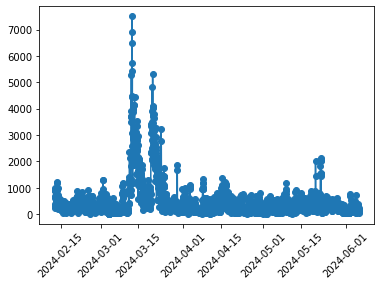

In [7]:
from collections import Counter
import matplotlib.pyplot as plt


x, y = zip(*sorted(Counter([e['date_hour'] for e in cortes]).items()))
plt.plot(x, y, '-o')
plt.xticks(rotation=45);

In [8]:
len(demanda_df)

64807

In [9]:
region2str = {
    1077: 'EDESUR',  1078: 'EDENOR', 
}

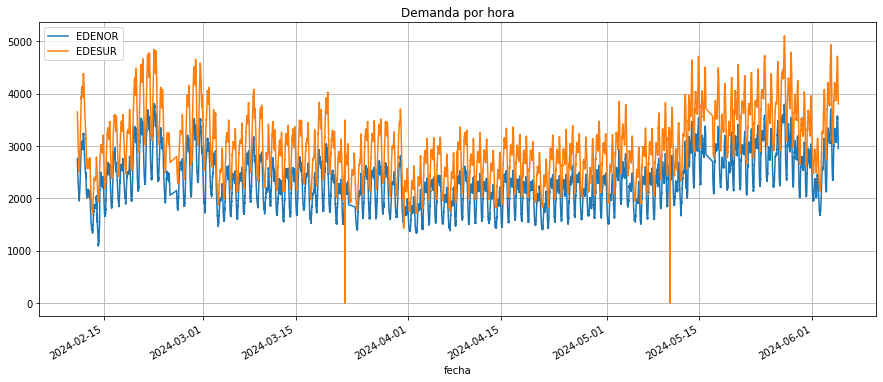

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.title('Demanda por hora')
for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').sort_index().dem.plot(label=region2str[region])
    
plt.legend(loc='best')
plt.grid();

In [11]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)
cortes_df['region'] = cortes_df.empresa.apply(lambda e: 1077 if e == 'EDESUR S.A.' else 1078)


In [12]:
s = cortes_df.date_hour.sort_values().diff().value_counts()[1:].sort_values()
s

date_hour
0 days 15:00:00       1
0 days 18:00:00       1
0 days 07:00:00       2
0 days 03:00:00       3
0 days 02:00:00      38
0 days 01:00:00    2611
Name: count, dtype: int64

In [13]:
clima_df = pd.DataFrame(clima)
clima_df['date_hour'] = clima_df.datetime.apply(lambda x: x.replace(minute=0))
clima_df['temperatura'] = clima_df['temperatura'].astype('int')

In [14]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,19:55,3732,3137,04d,Muy Nuboso,24,2024-02-26 19:55:00,2024-02-26 19:00:00
1,20:00,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:00:00,2024-02-26 20:00:00
2,20:05,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:05:00,2024-02-26 20:00:00
3,20:10,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:10:00,2024-02-26 20:00:00
4,20:15,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:15:00,2024-02-26 20:00:00


In [15]:
clima_df_hour = (
    clima_df.groupby('date_hour')
            .agg({'estado_cielo': pd.Series.mode, 'ufs_edesur': 'mean', 
                  'ufs_edenor': 'mean', 'temperatura': 'mean'})
           .reset_index()
)

In [16]:
len(clima_df_hour)

2719

In [17]:
clima_df_hour.head()

,date_hour,estado_cielo,ufs_edesur,ufs_edenor,temperatura
0,2024-02-11 15:00:00,Cielo Claro,24617.105263,2647.0,33.105263
1,2024-02-11 16:00:00,Nubes Dispersas,18497.666667,2647.0,32.416667
2,2024-02-11 17:00:00,Nubes Dispersas,17725.666667,2647.0,32.000000
3,2024-02-11 18:00:00,Algo De Nubes,16190.750000,2647.0,32.000000
4,2024-02-11 19:00:00,Cielo Claro,24054.750000,3202.5,31.166667


In [18]:
demanda_df['date_hour'] = demanda_df.fecha.apply(lambda x: x.replace(minute=0))
demanda_df_hour = (
    demanda_df.groupby(['date_hour', 'region'])
            .agg({'dem': 'mean'})
            .reset_index()
)

In [19]:
merged = (
    cortes_df.merge(clima_df_hour, left_on='date_hour', right_on='date_hour')
             .merge(demanda_df_hour, left_on=('date_hour', 'region'), right_on=('date_hour', 'region'))
)

In [20]:
len(cortes_df), len(clima_df), len(merged)

(1227305, 43488, 1190152)

In [21]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

0

In [22]:
(len(cortes_df) - len(merged)) #/ len(cortes_df)

37153

In [23]:
merged = (
    cortes_df.merge(demanda_df_hour, 
                    left_on=('date_hour', 'region'), right_on=('date_hour', 'region'), 
                    how='left')
            .merge(clima_df_hour, 
                    left_on='date_hour', right_on='date_hour',how='left')
)

In [24]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

25222

In [25]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

25222

<AxesSubplot:xlabel='fname_date'>

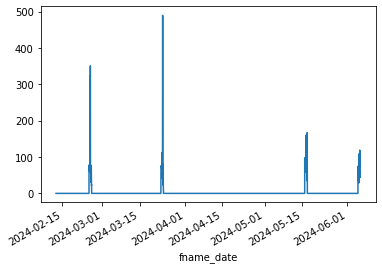

In [26]:

merged.groupby('fname_date').not_dem.sum().plot()

In [27]:
len(cortes_df), len(clima_df), len(merged)

(1227305, 43488, 1227305)

In [28]:
len(cortes_df) - len(merged)

0

In [29]:
merged['not_clima'] = merged.estado_cielo.isna()
merged.not_clima.sum()

12867

In [30]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

25222

In [31]:
37787 / len(merged) 

0.030788597781317602

<AxesSubplot:xlabel='date_hour'>

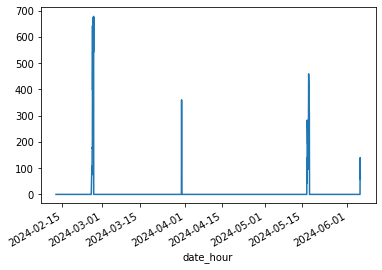

In [32]:
merged.groupby('date_hour').not_clima.sum().plot()

<AxesSubplot:xlabel='fname_date'>

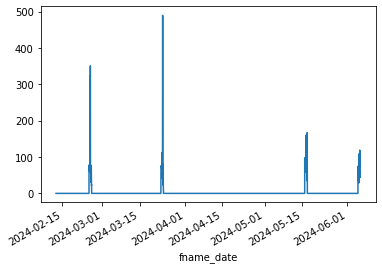

In [33]:
s = merged.groupby('fname_date').not_dem.sum()
s.plot()

In [34]:
demanda_df.head()

,fecha,region,dem,date_hour
0,2024-04-16 00:00:00,1078,1944,2024-04-16
1,2024-04-16 00:05:00,1078,1922,2024-04-16
2,2024-04-16 00:10:00,1078,1907,2024-04-16
3,2024-04-16 00:15:00,1078,1886,2024-04-16
4,2024-04-16 00:20:00,1078,1865,2024-04-16


In [35]:
demanda_df['hour'] = demanda_df.fecha.apply(lambda x:x.hour)
demanda_df.groupby('hour').dem.count()

hour
0     2707
1     2700
2     2700
3     2700
4     2700
5     2700
6     2700
7     2700
8     2700
9     2700
10    2700
11    2700
12    2700
13    2700
14    2700
15    2700
16    2700
17    2700
18    2700
19    2700
20    2700
21    2700
22    2700
23    2700
Name: dem, dtype: int64

<AxesSubplot:xlabel='hour'>

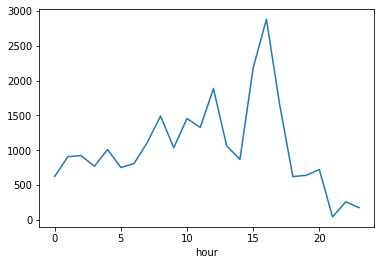

In [36]:
merged['hour'] = merged.fname_date.apply(lambda x: x.hour)
s = merged.groupby('hour').not_dem.sum()
s.plot()

<AxesSubplot:xlabel='date_hour'>

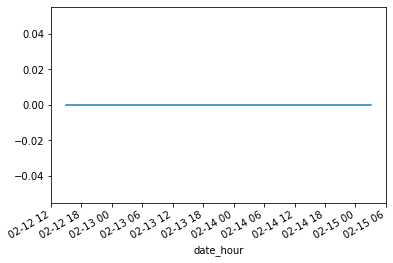

In [37]:
s = merged.groupby('date_hour').not_dem.sum()[:60]
s.plot()

/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


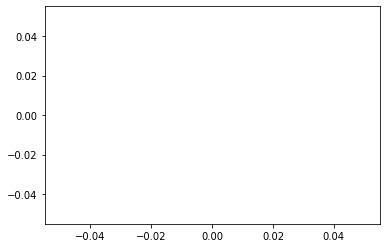

In [38]:
plt.plot([s.autocorr(lag=i) for i in range(1, 100)])

In [39]:
pd.options.display.max_columns = 1000

In [40]:
merged.head()

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,fname_date,date_hour,region,dem,estado_cielo,ufs_edesur,ufs_edenor,temperatura,not_dem,not_clima,hour
0,-34.748499,-58.301172,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,QUILMES,QUILMES OESTE,QUILMES,R:073-4-47/073-4-47,186,Sin datos,2024-06-02 09:10:00,2024-06-02 09:00:00,1077,2513.25,Nubes,2610.166667,1073.5,13.333333,False,False,9
1,-34.747851,-58.299997,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,QUILMES,QUILMES OESTE,QUILMES,R:073-4-47/073-4-47,154,Sin datos,2024-06-02 09:10:00,2024-06-02 09:00:00,1077,2513.25,Nubes,2610.166667,1073.5,13.333333,False,False,9
2,-34.750117,-58.304055,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,QUILMES,QUILMES OESTE,QUILMES,R:073-4-47/073-4-47,73,Sin datos,2024-06-02 09:10:00,2024-06-02 09:00:00,1077,2513.25,Nubes,2610.166667,1073.5,13.333333,False,False,9
3,-34.744149,-58.292308,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,QUILMES,QUILMES OESTE,QUILMES,R:073-4-47/073-4-47,2,Sin datos,2024-06-02 09:10:00,2024-06-02 09:00:00,1077,2513.25,Nubes,2610.166667,1073.5,13.333333,False,False,9
4,-34.600791,-58.398259,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,BALVANERA RP,AZCUENAGA,R:021-1-14/021-1-14,588,2024-06-02 13:39,2024-06-02 09:10:00,2024-06-02 09:00:00,1077,2513.25,Nubes,2610.166667,1073.5,13.333333,False,False,9


# Preguntas

1) Sube la demanda cuando aumenta la temperatura?

2) Cuales son las zonas con mas demanda (con la data que tenemos no la podemos contestar)

3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?

4) El estado del cielo correlaciona con la demanda y con los cortes?

5) Hay algun horario de mayor cantidad de cortes?

6) Cuales son las zonas con mas usuarios afectados? 


### 1) Sube la demanda cuando aumenta la temperatura?


In [58]:
merged.fname_date.apply(lambda x: x.hour==10).sum()

60077

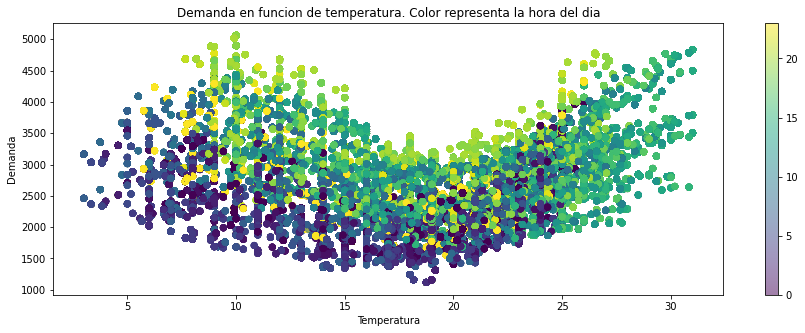

In [74]:
plt.figure(figsize=(15,5))

plt.scatter(merged.temperatura, merged.dem, c=merged.fname_date.apply(lambda x: x.hour), alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Demanda')
plt.title('Demanda en funcion de temperatura. Color representa la hora del dia')
plt.colorbar();

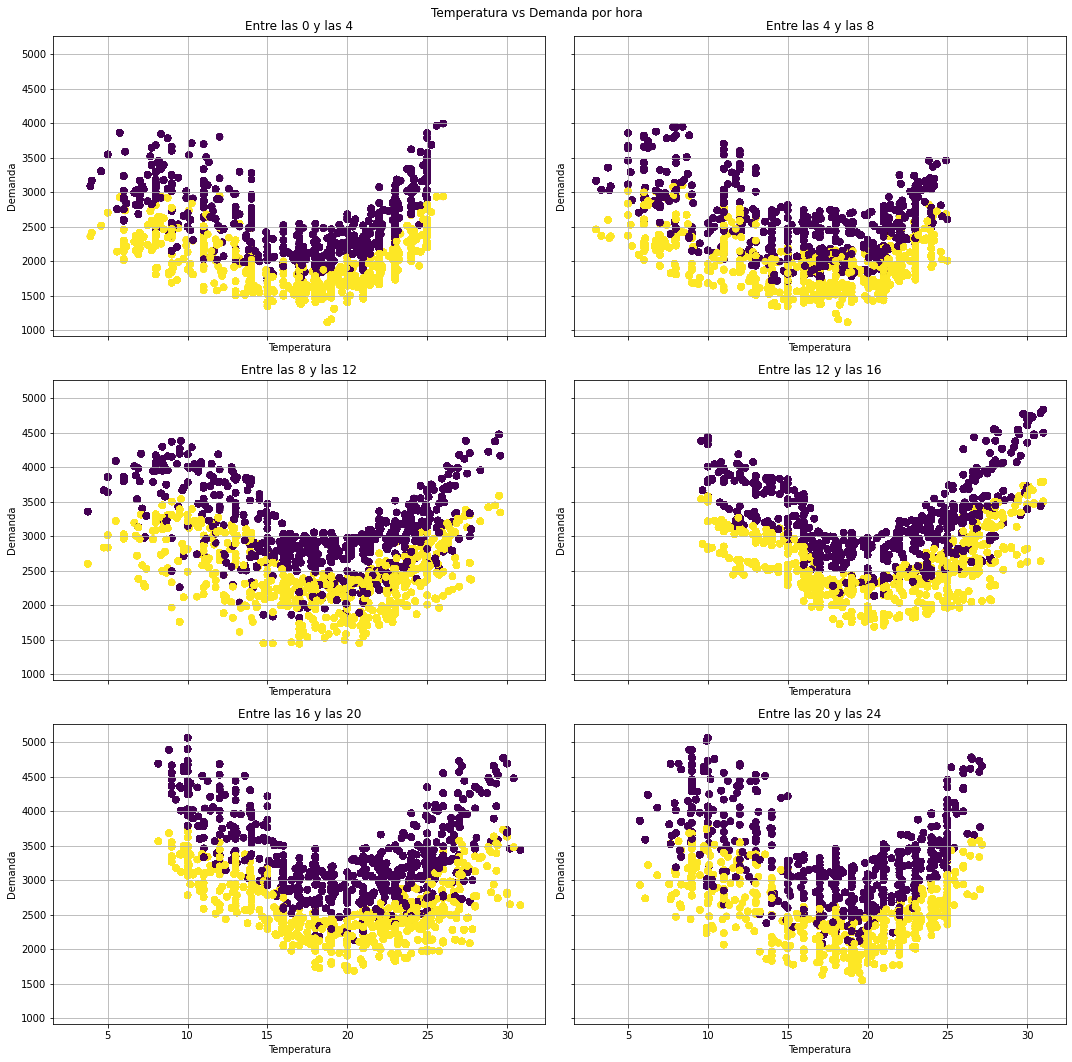

In [69]:
fig, subplots = plt.subplots(3,2,figsize=(15,15), sharex=True, sharey=True)
subplots = subplots.reshape(-1)

for i, lower_h in enumerate(range(0, 24, 4)):
    upper_h = lower_h + 4
    mask = merged.fname_date.apply(lambda x: x.hour>=lower_h and x.hour < upper_h)
    ax = subplots[i]
    ax.scatter(merged[mask].temperatura, merged[mask].dem, c=merged[mask].region)
    ax.set_xlabel('Temperatura')
    ax.set_ylabel('Demanda')
    ax.set_title(f'Entre las {lower_h} y las {upper_h}')
    ax.grid()

plt.suptitle('Temperatura vs Demanda por hora')
plt.tight_layout();

### 3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?


In [42]:
cortes_df['partido_localidad'] = cortes_df.partido + "/" + cortes_df.localidad

In [43]:
cortes_df.partido_localidad.value_counts().head(5)

partido_localidad
SAN FERNANDO/DELTA 2DA SECCION (SF)    135949
TIGRE/DELTA 1RA SECCION (TI)            71260
SAN VICENTE/SAN VICENTE                 65011
FLORENCIO VARELA/FLORENCIO VARELA       58190
SAN FERNANDO/DELTA 3RA SECCION (SF)     39120
Name: count, dtype: int64

### 4) El estado del cielo correlaciona con la demanda y con los cortes?


In [44]:
clima_df.estado_cielo.value_counts()

estado_cielo
Cielo Claro                     17380
Nubes                            6479
Muy Nuboso                       5975
Algo De Nubes                    4148
Nubes Dispersas                  3968
Lluvia Ligera                    1635
Lluvia Moderada                  1080
Niebla                            998
Llovizna Ligera                   677
Tormenta Con Lluvia Ligera        297
Lluvia De Gran Intensidad         206
Tormenta Con Lluvia               174
Llovizna                          123
Bruma                             107
Tormenta                           94
Tormenta Con Lluvia Intensa        84
Polvo                              28
Llovizna De Gran Intensidad        20
Lluvia Muy Fuerte                   6
Chubasco                            4
Lluvia Y Llovizna                   4
Arena                               1
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x7f95353ef400>], [Text(1, 0, 'dem')])

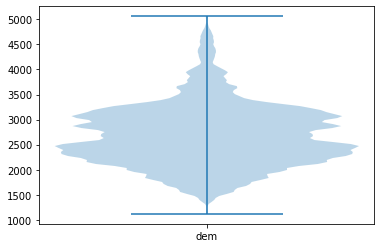

In [47]:
plt.violinplot(merged.dem.dropna())
plt.xticks([1], ['dem'])

In [48]:
temp_merged = merged.dropna(subset=['temperatura']).copy()

([<matplotlib.axis.XTick at 0x7f9546f9c730>],
 [Text(1, 0, 'usuarios afectados')])

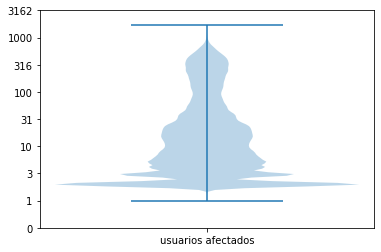

In [49]:
import numpy as np

plt.violinplot(np.log10(merged['usuarios afectados'] + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

([<matplotlib.axis.XTick at 0x7f95472b9eb0>],
 [Text(1, 0, 'usuarios afectados')])

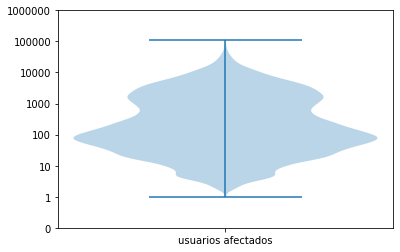

In [50]:
u = merged.groupby(['partido', 'date_hour'])['usuarios afectados'].sum()
plt.violinplot(np.log10(u + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

In [51]:
g = temp_merged.groupby('binned_temperature')['usuarios afectados']
g.mean().sort_index().plot(marker='o')


plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

g.count().sort_index().plot(secondary_y=True, marker='o')

plt.ylabel('# muestras por bucket')

KeyError: 'binned_temperature'

In [ ]:
g = temp_merged[~temp_merged.dem.isna()].groupby('binned_temperature')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

In [ ]:
g = merged[~merged.demHoy.isna()].groupby('binned_temperature')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

In [ ]:
g = merged.groupby('binned_temperature')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

In [223]:
merged['binnedDemanda'] = merged.demHoy.apply(lambda x: int(round(x, 0))//100*100 if not np.isnan(x) else x )

Text(0.5, 0, 'demanda')

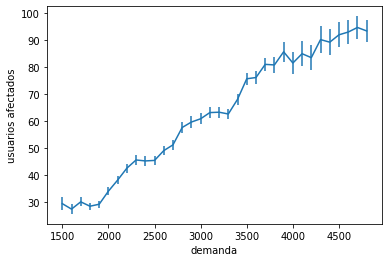

In [224]:
g = merged[~merged.demHoy.isna()].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().rolling(5).mean().dropna()
std = g.std().sort_index().rolling(5).mean().dropna() / (g.count().sort_index().rolling(5).mean().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

Text(0.5, 0, 'demanda')

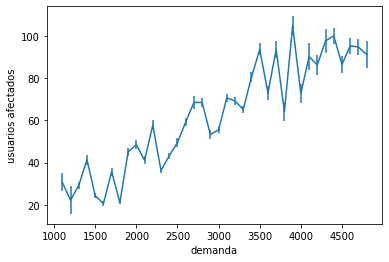

In [226]:
g = merged[~merged.demHoy.isna()].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

In [229]:
merged.to_csv('a.csv')
a = pd.read_csv('a.csv')

In [235]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,01:20,41164,1969,01n,Cielo Claro,26,2024-02-11 01:20:00,2024-02-11 01:00:00
1,01:25,41164,1969,01n,Cielo Claro,26,2024-02-11 01:25:00,2024-02-11 01:00:00
2,01:30,38574,1969,01n,Cielo Claro,26,2024-02-11 01:30:00,2024-02-11 01:00:00
3,01:35,38574,1969,01n,Cielo Claro,25,2024-02-11 01:35:00,2024-02-11 01:00:00
4,01:40,38574,1969,01n,Cielo Claro,25,2024-02-11 01:40:00,2024-02-11 01:00:00


<AxesSubplot:xlabel='temperatura'>

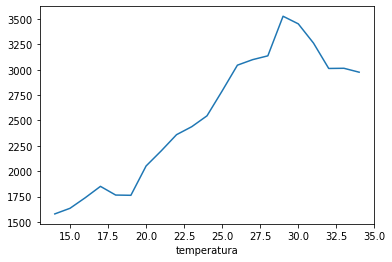

In [240]:
clima_df.merge(demanda_df, on='date_hour').groupby('temperatura').demHoy.mean().sort_index().plot()

In [239]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

estado_cielo
Nubes                           3080.761733
Algo De Nubes                   2927.881699
Nubes Dispersas                 2847.139645
Muy Nuboso                      2759.567203
Cielo Claro                     2686.762961
Lluvia De Gran Intensidad       2490.611538
Lluvia Ligera                   2465.537234
Lluvia Moderada                 2454.179167
Tormenta Con Lluvia Ligera      2068.166667
Tormenta Con Lluvia Intensa     2032.583333
Tormenta Con Lluvia             2032.557087
Name: demHoy, dtype: float64

In [243]:
clima_df.groupby('estado_cielo').temperatura.mean().sort_values(ascending=False)

estado_cielo
Algo De Nubes                   28.055339
Nubes Dispersas                 27.064066
Cielo Claro                     26.048100
Muy Nuboso                      25.470725
Nubes                           24.700000
Lluvia Ligera                   24.647287
Lluvia Moderada                 23.688581
Tormenta Con Lluvia Ligera      22.000000
Lluvia De Gran Intensidad       21.028571
Tormenta Con Lluvia             20.288889
Tormenta Con Lluvia Intensa     20.000000
Name: temperatura, dtype: float64

In [ ]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

In [230]:
(
    a[~merged.demHoy.isna()].groupby('estado_cielo')
          .agg({'region': 'count', 'demHoy': 'mean'})
          .rename(columns=dict(region='cortes'))
          .sort_values('cortes', ascending=False)
)

,cortes,demHoy
estado_cielo,,
Cielo Claro,38723,2933.123636
Algo De Nubes,15892,2851.188700
Muy Nuboso,14776,2622.964800
Nubes Dispersas,14446,2753.606251
Nubes,9525,3293.536658
['Cielo Claro ' 'Nubes '],567,3741.761317
Lluvia Moderada,273,3162.240842
['Lluvia Moderada ' 'Nubes Dispersas '],242,3153.477961
Lluvia Ligera,124,2258.887097


In [109]:
plt.scatter(merged)

<module 'matplotlib.pyplot' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
demanda_df, cortes_df, clima_df

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [38]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
R:TIGRE/153-TR2/153-5526           5276
R:15-2521                          4727
R:                                 2531
N:                                 2084
R:185-1-16/185-1-16                2067
                                   ... 
R:TORTUGUITAS/252-TR2/252-5534        1
R:FORD/151-TR2/151-5531               1
R:ALTOS/272-TR2/272-5533              1
R:ARA SAN JUAN/362-TR2/362-5525       1
R:SAN JUSTO/164-TR1/164-5512          1
Name: latitud, Length: 454, dtype: int64

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


# ni idea

In [287]:
c1 = {e['datetime']: e  for e in parse_clima('data/clima-enre-2024-03-10T20:10.txt.gz')}

In [288]:
c2 = {e['datetime']: e  for e in parse_clima('data/clima-enre-2024-03-10T21:50.txt.gz')}

In [292]:
inters = list(set(c1).intersection(c2))

for dt in inters:
    if c1[dt] != c2[dt]: 1/0

In [286]:
c1

[{'hour': '21:40',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 40)},
 {'hour': '21:45',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 45)},
 {'hour': '21:50',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 50)},
 {'hour': '21:55',
  'ufs_edesur': 7869,
  'ufs_edenor': 954,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 55)},
 {'hour': '22:00',
  'ufs_edesur': 7869,
  'ufs_edenor': 954,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 22, 0)},
 {'hour': '22:05',
  'ufs_edesur': 786

In [277]:
!ls data | grep clim

clima-enre-2024-02-11T13.txt
clima-enre-2024-02-11T13.txt.gz
clima-enre-2024-02-11T14.txt.gz
clima-enre-2024-02-11T15.txt.gz
clima-enre-2024-02-11T16.txt.gz
clima-enre-2024-02-11T17.txt.gz
clima-enre-2024-02-11T18.txt.gz
clima-enre-2024-02-11T19.txt.gz
clima-enre-2024-02-11T20.txt.gz
clima-enre-2024-02-11T22.txt.gz
clima-enre-2024-02-11T23.txt.gz
clima-enre-2024-02-12T00.txt.gz
clima-enre-2024-02-12T01.txt.gz
clima-enre-2024-02-12T02.txt.gz
clima-enre-2024-02-12T03.txt.gz
clima-enre-2024-02-12T04.txt.gz
clima-enre-2024-02-12T05.txt.gz
clima-enre-2024-02-12T06.txt.gz
clima-enre-2024-02-12T07.txt.gz
clima-enre-2024-02-12T08.txt.gz
clima-enre-2024-02-12T09.txt.gz
clima-enre-2024-02-12T10.txt.gz
clima-enre-2024-02-12T11.txt.gz
clima-enre-2024-02-12T12.txt.gz
clima-enre-2024-02-12T13.txt.gz
clima-enre-2024-02-12T14.txt.gz
clima-enre-2024-02-12T15:09.txt.gz
clima-enre-2024-02-12T15:30.txt.gz
clima-enre-2024-02-12T20:11.txt.gz
clima-enre-2024-02-12T21:50.txt.gz
clima-enre-2024-02-13T20:10.txt

In [233]:
demanda_df.fecha.sort_values().diff().value_counts()

0 days 00:00:00    9506
0 days 00:05:00    9504
1 days 00:00:00       1
Name: fecha, dtype: int64

# Algoritmo duracion cortes

In [92]:
cortes_df.subestacion.isna().sum() / len(cortes_df)

0.24566469785328013

In [20]:
for c in cortes:
    if 'subestacion' in c:
        c['id'] = c['subestacion']
    else:
        c['id'] = c['localidad']

In [134]:
from itertools import groupby

# Algoritmo de Maru :heart:
cortes.sort(key=lambda x: (x['id'], x['date_hour']))

for id, id_cortes in groupby(cortes, key=lambda x: x['id']):
    last_hour = None
    current = []
    id_cortes = list(id_cortes)
    import ipdb;ipdb.set_trace()
    for corte in id_cortes:
        if last_hour is None:
            last_hour = corte['date_hour']
            current.append(corte)
            
        elif (corte['date_hour'] - last_hour).total_seconds() <= 30*60:
            last_hour = corte['date_hour']
            current.append(corte)
            
        else:
            duration = current[-1]['date_hour'] - current[0]['date_hour']
            for c in current:
                c['real_duration'] = duration
                
            current = [corte]
    
    if current:
        duration = current[-1]['date_hour'] - current[0]['date_hour']
        for c in current:
            c['real_duration'] = duration

    
    

> /var/folders/55/555sz06s5477c_l2bss1ndnwmmmmq7/T/ipykernel_4502/2065986696.py(11)<cell line: 6>()
     10     import ipdb;ipdb.set_trace()
---> 11     for corte in id_cortes:
     12         if last_hour is None:

ipdb> q


BdbQuit: 

In [21]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

TypeError: tuple indices must be integers or slices, not str